In [1]:
import fenics
import time

import seaborn as sns
import pandas as pd
import numpy as np
import chaospy as cpy
import matplotlib.pyplot as plt

from copy import deepcopy
from chaospy import Normal, Uniform, generate_expansion

from source.models.high_fidelity import HighFidelityModel
from source.models.chaos_expansion import PCESurrogate
from source.core.metropolis_hastings import metropolis_hastings, adaptive_multifidelity_mh

We want to simulate the posterior distribution
of the parameter z (that in our case is
bidimensional). We perform a Metropolis-Hasting
algorithm both with the high-fidelity
(computationally very expensive) and low-fidelity
(computationally less expensive, but based only
on an approximation of the forward model), moreover
we simulate the posterior through the multi_fidelity
approach, which is still based on an approximation,
but the latter is often updated in order to better
fit the forward model (in the parameter with higher
posterior), still having a reasonable computational
cost.

We are importing a class which represents
the Poisson equation in the unitary domain.
We can use an object PoissonEquation as
callable object in order to obtain the value
of the solution in the spatial nodes of
interest.

In [ ]:
from source.examples.poisson_multifidelity import PoissonEquation

In [3]:
fenics.set_log_level(30)
np.random.seed(1226)
sns.set_style('whitegrid')



We initialize the forward model as the solution
of the bidimensional Poisson equation with
homogeneous boundary conditions, and, with
a guess parameter and function f specified
as inputs. Morevoer we indicates the
meshgrid.shape for dividing the unit square
domain in 32x32 rectangles, used for the
numerical solution of the equation.

In [5]:
forward_model = PoissonEquation(
    np.array([32, 32]), 'exp(-100*(pow(x[0] - param0, 2) + pow(x[1] - param1, 2)))',
    np.array([.5, .5]), '0')

We now want to generate a sample of 100
observations from a generated model.
For doing this, we first generate 100 spatial
samples from the domain of the pde (avoiding
to pick values from the boundary) and after we
generate data using the forward model for a fixed
value of the parameter (true_z) adding a gaussian
noise.




In [6]:
tol = 1e-5
num_data = 100
noise_sigma = .75
true_z = np.array([.25, .75])
x = np.random.uniform(0 + tol, 1 - tol, size=(2, num_data))
true_vals = forward_model(true_z, x)
data = true_vals + np.random.normal(0, noise_sigma, size=true_vals.shape)

Contour plot of the real model

<ipython-input-4-975380260772>:31: RuntimeWarning: divide by zero encountered in log
  np.log(self.u.compute_vertex_values(self.mesh).reshape(*(self.grid_shape + 1))),


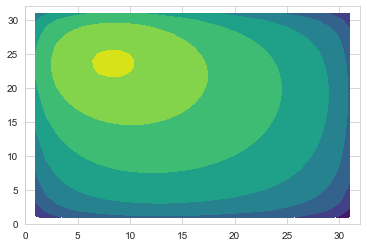

In [16]:
forward_model.plot(true_z)

We specify as prior for the bidimensional parameter
the distribution of two independent uniform(tol,1-tol),
as error density (used for computing the likelihood)
a gaussian(0,noise_sigma) and as proposal q(z1|z2)
a uniform centered in z2 with a certain radius
specified as input

In [7]:
dim = 2
prior = cpy.Iid(Uniform(0 + tol, 1 - tol), dim)

In [8]:
def log_prior(z_):
    z_ = np.min([z_, np.ones_like(z_) - tol], axis=0)
    z_ = np.max([z_, np.zeros_like(z_) + tol], axis=0)
    return np.log(prior.pdf(z_))

def log_err_dens(x_):
    return np.sum(-x_**2/(2*noise_sigma**2))

class UnifProposal:
    def __init__(self, r):
        self.r = r

    def draw(self, z):
        lbs = np.max([z - self.r, np.zeros_like(z) - tol], axis=0)
        ubs = np.min([z + self.r, np.ones_like(z) + tol], axis=0)
        return np.random.uniform(lbs, ubs, size=z.shape)

    def logdensity(self, z1, z2):
        lbs = np.max([z2 - self.r, np.zeros_like(z2) - tol], axis=0)
        ubs = np.min([z2 + self.r, np.ones_like(z2) + tol], axis=0)
        dens = 1./np.prod(ubs-lbs)
        return np.log(dens) if np.all(np.abs(z1 - z2) <= self.r) else -np.inf

We generate the high-fidelity and the low-fidelity
models

In [9]:
hfm = HighFidelityModel(
    forward_model, data, x, log_err_dens, log_prior)

lfm = PCESurrogate(data, log_err_dens, prior, log_prior, 2, 10)
lfm.fit(hfm)

mfm = deepcopy(lfm)

We define as proposal q(.|z) uniform centered
in z with radius 0.05, and we define the
parameters that we have to pass to the
multi-fidelity algorithm. In particular we
will generate 10000 samples for the parameter
z, starting from the initial parameter init_z.
Every MH algorithm inside the algorithm will
generate 100 samples.

In [19]:
proposal = UnifProposal(.05)
samples = 10000
init_z = np.array([.5, .5])

subchain_len = 100
upper_th = 1e-4
error_th = 1e-2
init_radius = .1
rho = .9

In [20]:
lfmh_t = time.time()
lfmh = metropolis_hastings(lfm, proposal, init_z, samples)
lfmh_t = time.time() - lfmh_t

 99% |================================ | ETA:   0:00:00 - Elapsed Time: 0:01:28

In [21]:
hfmh_t = time.time()
hfmh = metropolis_hastings(hfm, proposal, init_z, samples)
hfmh_t = time.time() - hfmh_t

 99% |================================ | ETA:   0:00:00 - Elapsed Time: 0:02:26

In [22]:
mfmh_t = time.time()
mfmh = adaptive_multifidelity_mh(
    subchain_len, samples // subchain_len, upper_th, error_th, init_radius, rho, mfm, hfm, proposal, init_z)
mfmh_t = time.time() - mfmh_t

100% |=================================| ETA:  00:00:00 - Elapsed Time: 0:01:27

In [23]:
print('\nperformance evaluation:')
print('\tlow fidelity:\t{:.2f}s ({:.4}s per iteration)'.format(lfmh_t, lfmh_t/samples))
print('\thigh fidelity:\t{:.2f}s ({:.4}s per iteration)'.format(hfmh_t, hfmh_t/samples))
print('\tmulti fidelity:\t{:.2f}s ({:.4}s per iteration)'.format(mfmh_t, mfmh_t/samples))


performance evaluation:
	low fidelity:	89.00s (0.0089s per iteration)
	high fidelity:	146.20s (0.01462s per iteration)
	multi fidelity:	87.85s (0.008785s per iteration)


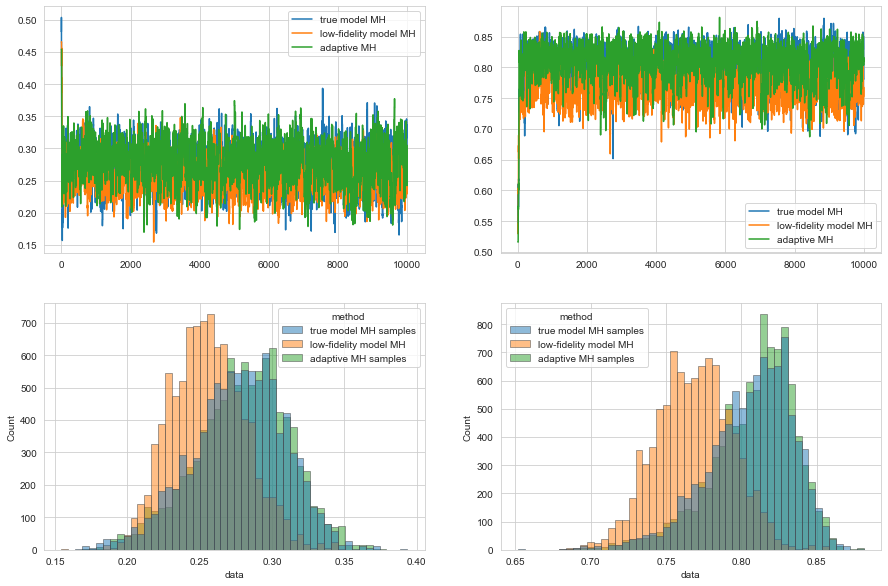

In [24]:
plt.figure(figsize=(15, 10))

for i in range(2):
    plt.subplot(2, 2, i+1)
    plt.plot(hfmh[i, :], label='true model MH')
    plt.plot(lfmh[i, :], label='low-fidelity model MH')
    plt.plot(mfmh[i, :], label='adaptive MH')
    plt.legend()

burn = 400
for i in range(2):
    plt.subplot(2, 2, i+3)

    mh_data = pd.DataFrame({
        'data': np.concatenate([hfmh[i, burn:], lfmh[i, burn:], mfmh[i, burn:]], axis=0),
        'method':
            ['true model MH samples'] * (samples - burn) +
            ['low-fidelity model MH'] * (samples - burn) +
            ['adaptive MH samples'] * (samples - burn)})
    sns.histplot(
        mh_data,
        x='data',
        hue='method',
        bins=50,
        multiple='layer',
        edgecolor='.3',
        linewidth=.5)

plt.show()